In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from utils import *
from tqdm import tqdm
import datetime
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
# torch.set_default_dtype(torch.float32)



In [2]:

class LossClass:
    def __init__(self, reference_image_path, ref_im_size) -> None:
        """
        @param reference_image_path: path to the reference image
        @param ref_im_size: size of the reference image (resized to this size)
        """
        # Initialisation of the VGG19 model
        self.vgg_cnn = models.vgg19(weights="IMAGENET1K_V1").features.to(device)

        self.vgg_cnn.requires_grad_(False)

        # initialise l'extraction des couches pour la loss
        self.extracted_layers_indexes = [1, 6, 11, 20, 29]
        self.layers_weights = [1 / n**2 for n in [64, 128, 256, 512, 512]]

        # Contient la réponse des différentes couches de vgg à l'image de référence
        self.vgg_outputs = {}

        def save_output(name):

            # The hook signature
            def hook(module, module_in, module_out) -> None:
                self.vgg_outputs[name] = module_out

            return hook

        # le handle est useless
        for layer in self.extracted_layers_indexes:
            handle = self.vgg_cnn[layer].register_forward_hook(save_output(layer))

        # Charge l'image de référence et la prépare (resize, normalisation, etc.)
        self.reference_img = prep_img_file(reference_image_path, ref_im_size).to(device)

        # Calcul de la matrice de gramm pour chaque couche
        self.vgg_cnn(self.reference_img / 0.25)
        self.gramm_targets = [
            gramm(self.vgg_outputs[key]) for key in self.extracted_layers_indexes
        ]

    def compute_loss(self, imgs):
        # img : batch de 4 images de taille 12x128x128

        total_loss = torch.tensor(0.0).to(device)

        # Prepare texture data
        synth = []
        for i in range(4):
            synth.append(imgs[i][:3].unsqueeze(0))

        # Forward pass using target texture for get activations of selected layers (outputs). Calculate gram Matrix for those activations
        for x in synth:
            losses = []
            self.vgg_cnn(x / 0.25)
            synth_outputs = [
                self.vgg_outputs[key] for key in self.extracted_layers_indexes
            ]
            # calcul des loss pour toutes les couches

            for activations in zip(
                synth_outputs, self.gramm_targets, self.layers_weights
            ):
                losses.append(gram_loss(*activations).unsqueeze(0))

            total_loss = total_loss + torch.cat(losses).sum()
        clip_loss = torch.sum(torch.abs(imgs - imgs.clip(-1, 1))) / torch.numel(imgs)
        return total_loss + clip_loss




In [10]:

class RecursiveNN(nn.Module):
    def __init__(
        self,
        loss: LossClass,
        img_size=128,
        img_layer_depth=12,
        cpool_size=1024,
        learning_rate=2e-4,
        bach_size=4,
    ):
        super(RecursiveNN, self).__init__()

        self.loss = loss
        self.img_size = img_size
        self.img_layer_depth = img_layer_depth
        self.cpool_size = cpool_size
        self.learning_rate = learning_rate
        self.bach_size = bach_size

        self.ident = torch.tensor(
            [[0.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0]]
        ).to(device)
        self.sobel_x = torch.tensor(
            [[-1.0, 0.0, 1.0], [-2.0, 0.0, 2.0], [-1.0, 0.0, 1.0]]
        ).to(device)
        self.lap = torch.tensor([[1.0, 2.0, 1.0], [2.0, -12, 2.0], [1.0, 2.0, 1.0]]).to(
            device
        )

        self.cn1 = nn.Conv2d(
            4 * img_layer_depth, 96, kernel_size=1, padding=0, stride=1
        ).to(device)

        self.cn2 = nn.Conv2d(
            96,
            img_layer_depth,
            kernel_size=1,
            padding=0,
            stride=1,
            bias=False,  # Semble vraiment être important pour éviter la divergence
        ).to(device)

        # self.cn1.weight.data.zero_() Surtout pas, augmente énormément le temps de convergence
        self.cn2.weight.data.zero_()

        # Création de la pool d'images (avec les channels en plus)
        self.cpool = torch.rand(
            size=(self.cpool_size, self.img_layer_depth, self.img_size, self.img_size),
            dtype=torch.float32,
            requires_grad=False,
        ).to(device)

        self.total_training_steps = 0
        self.total_params = sum(p.numel() for p in self.parameters())

    def forward(self, x):
        """ "from the paper"""
        b, ch, h, w = x.shape
        filters = torch.stack([self.ident, self.sobel_x, self.sobel_x.T, self.lap]).to(
            device
        )

        y = x.reshape(b * ch, 1, h, w)
        y = torch.nn.functional.pad(y, [1, 1, 1, 1], "circular")
        y = torch.nn.functional.conv2d(y, filters[:, None])
        y = y.reshape(b, -1, h, w)

        """end of paper"""

        out = self.cn2(F.relu(self.cn1(y)))

        return out + x

    def render(self, it, width, height, save=True):

        x = torch.rand(
            size=(1, self.img_layer_depth, width, height), dtype=torch.float32
        ).to(device)
        # remplace un des éléments du batch par du bruit
        with torch.no_grad():
            for _ in range(it):
                x = self(x)

        if save:
            create_directory_if_not_exists("output")
            plt.imsave(
                f"output/{datetime.datetime.now().strftime('%m-%d_%H-%M')}_{it}_iterations.png",
                to_img(x),
            )
        return x
    def start_training(self, nb_steps, debug=False, save_on_interrupt=True):

        optim = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        self.train()  # met le modèle en mode entrainement
        loss_history = []

        # Progress bar
        pbar = tqdm(total=nb_steps)

        try:
            for i in range(nb_steps):

                indices = torch.randint(
                    low=0, high=self.cpool_size, size=(self.bach_size,)
                )
                # print(indices)
                current_batch = self.cpool[indices]

                # remplace une image du batch par du bruit
                current_batch[0] = torch.rand(
                    size=(self.img_layer_depth, self.img_size, self.img_size),
                    dtype=torch.float32,
                    requires_grad=False,
                ).to(device)
                # le clone est nécessaire ? Probablement pas, faut juste remplace le bon dans la pool
                current_batch = current_batch.clone().detach()

                # On applique itérativement le modèle sur l'image
                niter = torch.randint(low=32, high=64, size=(1,))
                for _ in range(niter):
                    current_batch = self(current_batch)

                L = self.loss.compute_loss(current_batch)

                with torch.no_grad():
                    L.backward()
                    for p in self.parameters():
                        p.grad /= p.grad.norm() + 1e-8  # normalize gradients
                    optim.step()
                    optim.zero_grad()

                # On met à jour la pool d'images
                self.cpool[indices] = current_batch.detach()

                pbar.set_description(
                    f"\rstep {i+1} / {nb_steps} | loss: {L.item():.3e} | extremums: [{torch.min(current_batch):.3e}, {torch.max(current_batch):.3e}]"
                )
                loss_history.append(L.item())
                pbar.update()
                self.total_training_steps += 1
        except KeyboardInterrupt:
            print("\ntraining interrupted !")

            if save_on_interrupt:
                self.save_weights()
            quit(1)

        pbar.close()

        # save loss history
        #plt.plot(loss_history)
        #plt.xlabel("Training Step")
        #plt.ylabel("Loss")
        #plt.title("Loss History")
        #plt.savefig(
        #    f"loss_history_{datetime.datetime.now().strftime('%m-%d_%H-%M')}_{self.total_training_steps}_steps.png"
        #)
        self.save_weights(save_loss=True)

    def save_weights(self, dir_path="trained_model",save_loss = True) -> None:


        create_directory_if_not_exists(dir_path)
        # cd trained_models
        os.chdir(dir_path)
        pathmodel = f"model_{datetime.datetime.now().strftime('%m-%d_%H-%M')}_{self.total_training_steps}_steps"
        create_directory_if_not_exists(pathmodel)

        filename = "model.pth"
        torch.save(self.state_dict(), f"{pathmodel}/{filename}")
        if save_loss:
            plt.savefig(f"{pathmodel}/loss.png")
        os.chdir('..')
    def load_weights(self, path):
        self.load_state_dict(torch.load(path))





step 50 / 50 | loss: 4.163e-02 | extremums: [-4.050e+00, 2.285e+00]: 100%|██████████| 50/50 [00:11<00:00,  4.51it/s]


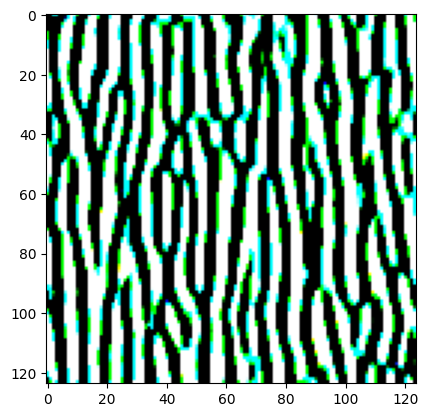

In [11]:
if __name__ == "__main__":

    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    np.random.seed(42)

    l = LossClass("/content/grid_0124.jpg", 128)
    model = RecursiveNN(l)

    model.start_training(50)


    finish = model.render(200, width=124, height=124)

    plt.imshow(to_img(finish))
    plt.show()
    torch.cuda.empty_cache()

[[[0.46111637 0.5605321  0.57073396]
  [0.54280657 0.6274056  0.65528643]
  [0.5662649  0.6296245  0.67895955]
  ...
  [0.2603782  0.2995279  0.35154617]
  [0.2666862  0.33450094 0.34989694]
  [0.32509455 0.41758135 0.42478514]]

 [[0.5002058  0.5960217  0.60781336]
  [0.5742801  0.659912   0.72409624]
  [0.5906527  0.6585839  0.76437217]
  ...
  [0.45889097 0.5366955  0.5412143 ]
  [0.31816763 0.42138124 0.38988176]
  [0.26631936 0.3609018  0.37047789]]

 [[0.52064234 0.62529093 0.60419965]
  [0.54634106 0.6235358  0.6824357 ]
  [0.54477066 0.6137465  0.7194364 ]
  ...
  [0.5796358  0.7127853  0.73263127]
  [0.29602236 0.43280903 0.41396043]
  [0.08851163 0.19666666 0.20321426]]

 ...

 [[0.25341886 0.31660715 0.3589831 ]
  [0.23952074 0.3096944  0.34321427]
  [0.22785898 0.30267346 0.32919052]
  ...
  [0.3047326  0.3470819  0.44460955]
  [0.2886446  0.33331224 0.40977776]
  [0.26861382 0.32282263 0.37806624]]

 [[0.06271602 0.13769865 0.16503274]
  [0.05921744 0.13926408 0.16968133]


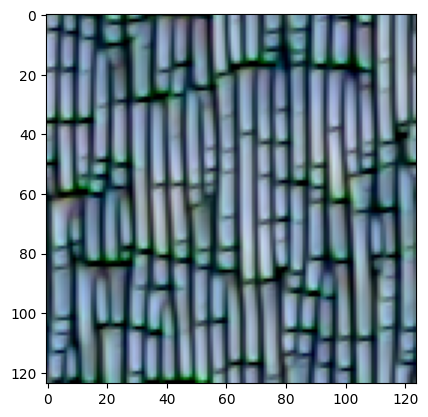

In [ ]:
l = LossClass("grid_0124.jpg", 128)
model = RecursiveNN(l)
model.load_weights("/content/trained_models/model_06-05_12-45_500_steps.pth")

finish = model.render(200, width=124, height=124)

plt.imshow(to_img(finish))
plt.show()
torch.cuda.empty_cache()
